In [1]:
import numpy as np
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

from nmrnet import *
import nmrMod as nmr

import torch as th
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
from safetensors.torch import load_model
from torchinfo import summary

#from collections.abc import Callable
from tqdm.notebook import trange, tqdm

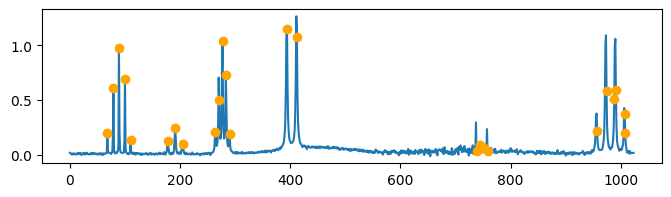

In [2]:
yy, res = nmr.generateRandomSpectrum(0)
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(yy["filtered"])
ax.scatter(res,[yy["filtered"][i] for i in res], c = "orange", zorder = 10)

In [3]:
ML = 500
ML_test = 500
batch_size = 64
train_set = NMRDataset(maxLen = ML, mode = "wide")
test_set = NMRDataset(maxLen = ML_test, startSeed = ML)

train_loader: DataLoader = DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=False,
    num_workers=2
)
test_loader: DataLoader = DataLoader(
    dataset=test_set,  batch_size=batch_size, shuffle=False,
    num_workers=2
)

In [4]:
device: th.device = th.device(
    "cuda" if th.cuda.is_available() else "cpu"
)
model: th.nn.Module = NMRSeq().to(device)
summary(model, input_size=(batch_size,1,nmr.nPts))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 1, 1024]             --
├─Inception_variant: 1-1                 [64, 136, 1024]           --
│    └─Inception_piece: 2-1              [64, 16, 1024]            --
│    │    └─Conv1d: 3-1                  [64, 1, 1025]             3
│    │    └─Conv1d: 3-2                  [64, 16, 1024]            48
│    └─Inception_piece: 2-2              [64, 32, 1024]            --
│    │    └─Conv1d: 3-3                  [64, 1, 1027]             5
│    │    └─Conv1d: 3-4                  [64, 32, 1024]            160
│    └─Inception_piece: 2-3              [64, 64, 1024]            --
│    │    └─Conv1d: 3-5                  [64, 1, 1031]             9
│    │    └─Conv1d: 3-6                  [64, 64, 1024]            576
│    └─Inception_piece: 2-4              [64, 16, 1024]            --
│    │    └─Conv1d: 3-7                  [64, 1, 1055]             33
│    │    └─Conv

In [5]:
epochs = 100
lossCriterion = nn.CrossEntropyLoss(reduction = 'mean')

In [ ]:
errArr = np.zeros(epochs)
testErrArr = np.zeros(epochs)
bar = trange(epochs)

for i in bar:
    modeltmp = NMRSeq().to(device)
    load_model(model, f"./cross100/narrow/modelpars_narrow_it_{i}.safetensors")
    modeltmp.eval()
    
    err = 0.
    testErr = 0.
    
    with th.no_grad():
        #Train
        for i, batched_datapoint_e in enumerate(train_loader):
            bar.set_description_str(desc = f"train, {i}")
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = modeltmp(x_e)
            err += lossCriterion(modeltarget_e, y_e).item()
            
        #Test
        for i, batched_datapoint_e in enumerate(test_loader):
            bar.set_description_str(desc = f"test, {i}")            
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = modeltmp(x_e)
            testErr += lossCriterion(modeltarget_e, y_e)
        
        errArr[i] = err/ML
        testErrArr[i] = testErr/ML_test
    
    
    del modeltmp

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
load_model(model, "./cross100/modelpars_narrow_final.safetensors")

(set(), set())

In [13]:
dataiter = test_loader.__iter__()
x_a, y_a = dataiter.__next__()
QUANTO = 0
for i in range(QUANTO):
    x_a, y_a = dataiter.__next__()

In [14]:
x_a, y_a = x_a.to(device), y_a.to(device)
target = model(x_a)
k = target.detach().numpy()
sigk = th.special.expit(target).detach().numpy()

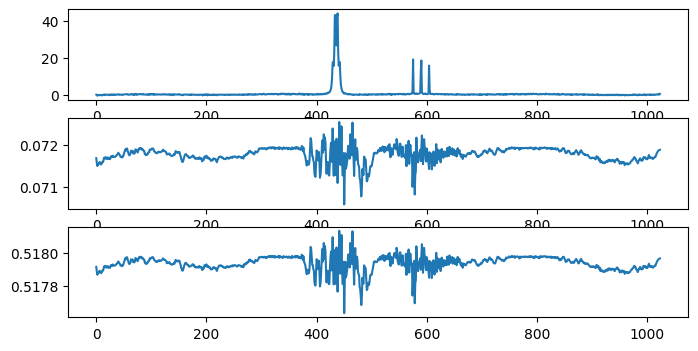

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(8, 4))
ax[0].plot(x_a[0][0])
ax[1].plot(k[0][0])
ax[2].plot(sigk[0][0])